In [2]:
install.packages("ggpubr")

library(dplyr)
library(tidyr)
library(ggplot2)
library(ggpubr)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



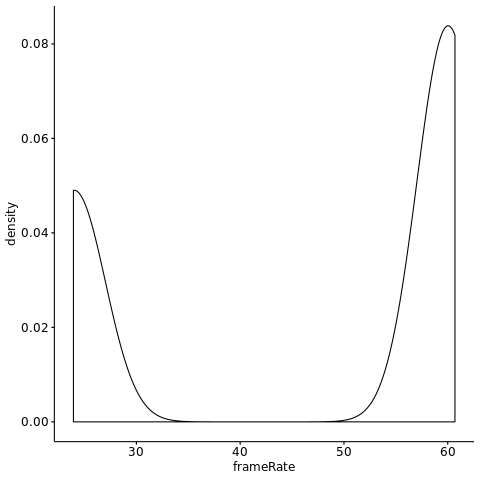

In [60]:
MID_long <- read.csv("/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/repo/fMRI-tasks/MID/data/MID_merged_bdat.csv")
MID_long$probeResp.corr <- as.integer(MID_long$probeResp.corr)
MID_long$run <- as.factor(MID_long$run)

# replace NA with 0s
MID_long$probeResp.corr[is.na(MID_long$probeResp.corr)] <- 0
MID_long$probeResp.rt[is.na(MID_long$probeResp.rt)] <- 0

MID_wide <- MID_long %>% 
  filter(Condition != "") %>%
  group_by(participant, Condition, run) %>%
  summarise(meanacc = mean(probeResp.corr), meanrt =1000* mean(probeResp.rt, na.rm=TRUE), frameRate = mean(frameRate))

# recategorize conditions
MID_wide <- MID_wide %>% mutate(cond = case_when(
        Condition == "LgPun" | Condition == "SmallPun" ~ "Loss",
        Condition == "LgReward" | Condition == "SmallReward" ~ "Reward", 
        Condition == "Triangle" ~ "Neutral")) 

MID_wide <- MID_wide %>% mutate(frameRate = case_when(
        frameRate < 40 ~  24,
        frameRate > 50 ~ 60))

MID_wide$frameRate <- as.factor(MID_wide$frameRate)

ggdensity(MID_long, x = "frameRate")



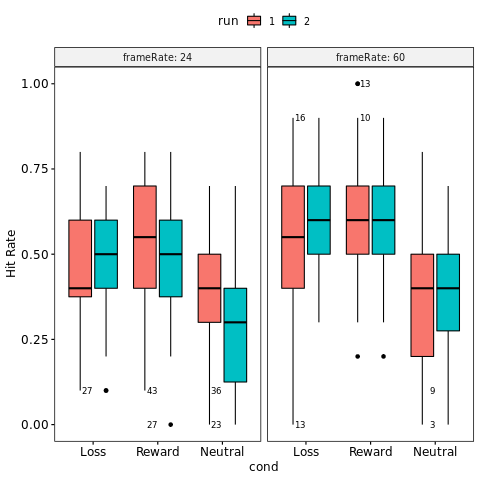

In [13]:
%%R

ggboxplot(MID_wide, "cond", "meanacc", fill = "run", ylab = "Hit Rate", facet.by = "frameRate", short.panel.labs = FALSE) + 
  geom_text(aes(label=ifelse((meanacc < quantile(meanacc, 0.25) - 1.5 * IQR(meanacc) | meanacc > quantile(meanacc, 0.75) + 1.5 * IQR(meanacc)),paste(participant),"")), hjust=1.1, check_overlap = TRUE, size=3, position = position_dodge(1))


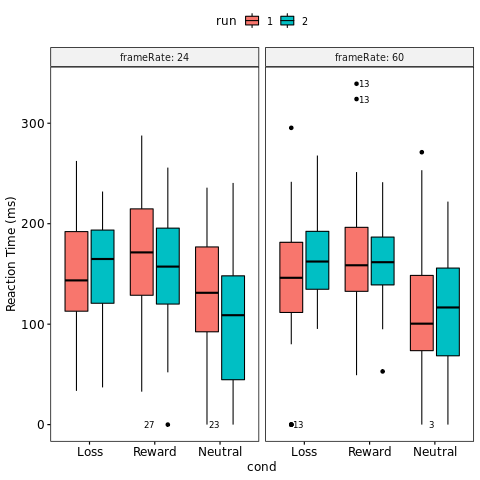

In [15]:
%%R
# meanrt is for correct trials only
ggboxplot(MID_wide, "cond", "meanrt", fill = "run", ylab = "Reaction Time (ms)", facet.by = "frameRate", short.panel.labs = FALSE) + 
  geom_text(aes(label=ifelse((meanrt < quantile(meanrt, 0.25) - 1.5 * IQR(meanrt) | meanrt > quantile(meanrt, 0.75) + 1.5 * IQR(meanrt)),paste(participant),"")), hjust=1.1, check_overlap = TRUE, size=3, position = position_dodge(1))

# SST

In [3]:
SST_long <- read.csv("/corral-secure/utdmc/Dell-Medical-Imaging/ULG/BIDS/derivatives/repo/fMRI-tasks/SST/data/SST_merged_bdat.csv")
SST_long$frameRate <- as.character(SST_long$frameRate)
SST_long$run <- as.factor(SST_long$run)

# manually change 038's framerate
SST_long$frameRate[SST_long$participant == 38 & SST_long$run == 1] <- 24

SST_long <- SST_long %>% mutate(frameRate = case_when(
        frameRate < 26 ~  24,
        frameRate > 58 ~ 60))

SST_long$frameRate <- as.factor(SST_long$frameRate)

# calculate corr go RT
SST_corr_go_rt <- SST_long %>%
  filter(trial_type == "go" & key_response.corr == 1) %>%
  group_by(participant, run) %>%
  summarise(go_correct_rt = 1000*mean(key_response.rt)) %>% ungroup()

# calc stop err RT
SST_stop_err_rt <- SST_long %>%
  filter(trial_type == "stop" & key_response.corr == 0) %>%
  group_by(participant, run) %>%
  summarise(stop_error_rt = 1000*mean(key_response.rt)) %>% ungroup() 

SST_wide <- SST_long %>% 
  filter(trial_type != "") %>%
  group_by(participant, trial_type, run, frameRate) %>%
  summarise(meanacc = mean(key_response.corr, na.rm = TRUE), meanrt = 1000* mean(key_response.rt, na.rm=TRUE), ssd = 1000*mean(ss_delay), stopError = sum(trial_type == "stop" & key_response.corr == 0), stopTotal = sum(trial_type == "stop"), GoCorr = sum(trial_type == "go" & key_response.corr == 1), GoTotal = sum(trial_type == "go")) %>% ungroup() 
            

SST_wide <- merge(SST_wide, SST_corr_go_rt, by = c('participant', 'run'))

SST_wide <- merge(SST_wide, SST_stop_err_rt, by = c('participant', 'run'))



SST_wide <- SST_wide %>% mutate(stopError_prop = stopError/stopTotal,
                    goCorr_prop = GoCorr/GoTotal)

SST_rt <- SST_wide %>% ungroup() %>% select(participant, run, frameRate, go_correct_rt, stop_error_rt, ssd) %>% gather(condition, value, go_correct_rt:ssd)

SST_rt_filt <- SST_wide %>% ungroup() %>% select(participant, run, frameRate, go_correct_rt, stop_error_rt, ssd) %>% filter(ssd > 95) %>% gather(condition, value, go_correct_rt:ssd)

SST_prop <- merge(SST_wide %>% ungroup() %>% subset(trial_type == "go") %>% select(participant, run, frameRate, goCorr_prop), SST_wide %>% ungroup() %>% subset(trial_type == "stop") %>% select(participant, run, frameRate, stopError_prop), by = c("participant", "run", "frameRate")) 

SST_prop <- gather(SST_prop, condition, value, goCorr_prop:stopError_prop)

SST_prop_filt <- merge(SST_wide %>% filter(ssd > 95) %>% ungroup() %>% subset(trial_type == "go") %>% select(participant, run, frameRate, goCorr_prop), SST_wide %>% ungroup() %>% subset(trial_type == "stop") %>% select(participant, run, frameRate, stopError_prop), by = c("participant", "run", "frameRate")) 
SST_prop_filt <- gather(SST_prop_filt, condition, value, goCorr_prop:stopError_prop)






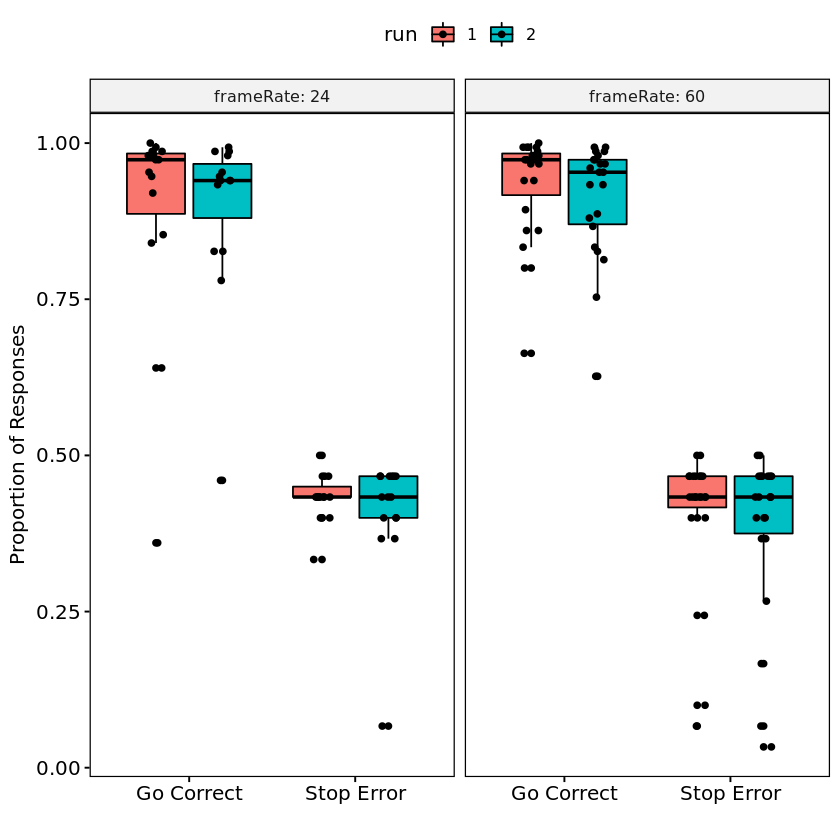

In [9]:
names(SST_prop)[names(SST_prop) == 'value'] <- 'prop'

SST_prop %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "prop", fill = "run", ylab = "Proportion of Responses", xlab = "", add = "jitter", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

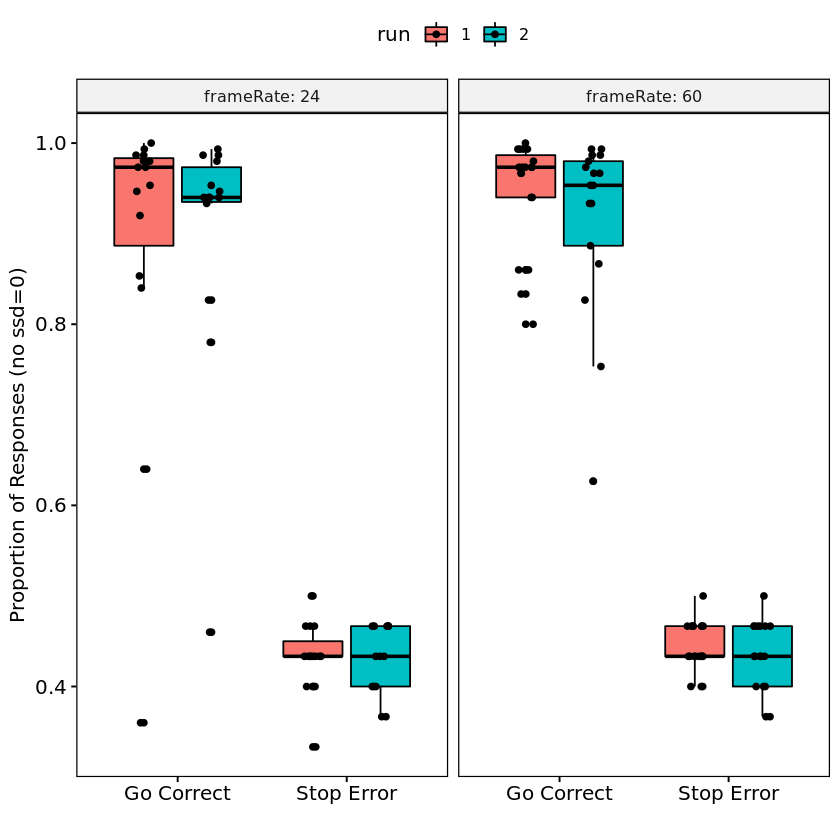

In [11]:
# filter out SSD = 0 
names(SST_prop_filt)[names(SST_prop_filt) == 'value'] <- 'prop'

SST_prop_filt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "prop", fill = "run", ylab = "Proportion of Responses (no ssd=0)", xlab = "", add = "jitter", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

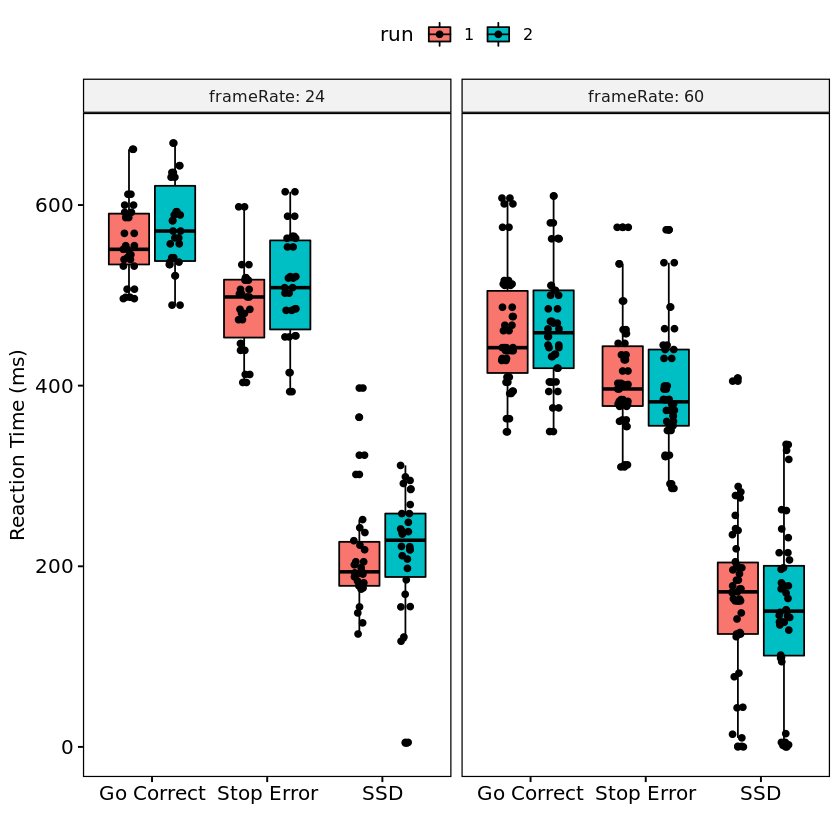

In [13]:
names(SST_rt)[names(SST_rt) == 'value'] <- 'RT'

SST_rt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "RT", fill = "run", ylab = "Reaction Time (ms)", xlab = "", add = "jitter", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

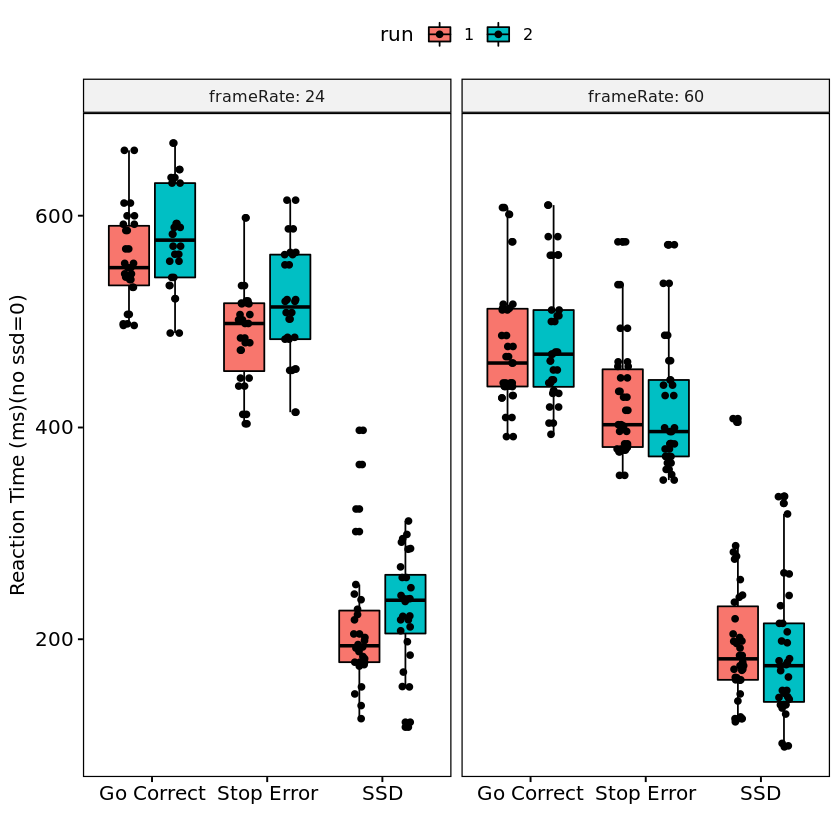

In [24]:
# filter out SSD = 0 

SST_rt_filt %>%
  group_by(condition, run) %>%
  ggboxplot(., "condition", "value", fill = "run", ylab = "Reaction Time (ms)(no ssd=0)", xlab = "", add = "jitter", facet.by = "frameRate", short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

# calculate SSRT
- method 1: median corr_go_rt minus mean SSD
- method 2: Go RT at the percentile corresponding to the proportion of unsuccessfully inhibited stop trials and subtracting the mean stop-signal delay

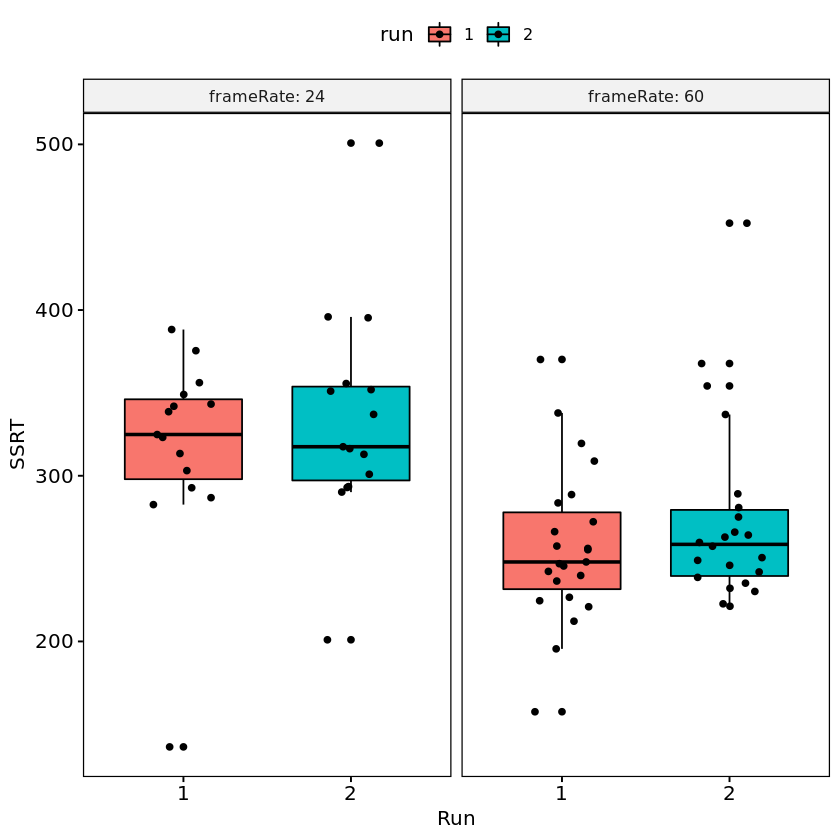

In [16]:
median_go_rt <- SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run, frameRate) %>%
  summarise(median = median(key_response.rt)) 

SST_long_stop_correct <- SST_long %>%
  filter(trial_type == 'stop' & key_response.corr == 1)

meanSSD <- SST_long_stop_correct %>% group_by(participant, run, frameRate) %>%
  summarise(meanSSD = mean(ss_delay)) 

SSRT <- merge(meanSSD, median_go_rt, by = c('participant','run', 'frameRate'))


mutate(SSRT, SSRT = 1000*(median - meanSSD)) %>%
  ggboxplot(., "run", "SSRT", fill = "run", ylab = "SSRT", xlab = "Run", facet.by = "frameRate", add = "jitter", short.panel.labs = FALSE)

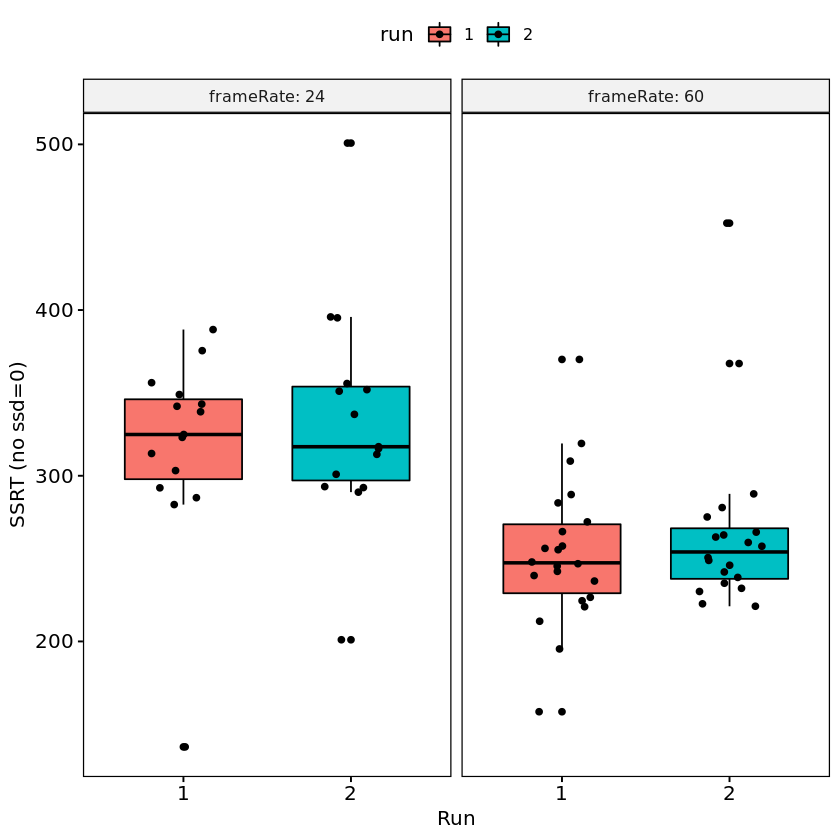

In [17]:
# filter out SSD = 0 
mutate(filter(SSRT, meanSSD > 0/.09), SSRT = 1000*(median - meanSSD)) %>%
  ggboxplot(., "run", "SSRT", fill = "run", ylab = "SSRT (no ssd=0)", xlab = "Run", facet.by = "frameRate", add = "jitter", short.panel.labs = FALSE)

In [28]:
mutate(SSRT, SSRT = 1000*(median - meanSSD)) %>% mutate(SSRT)

participant,run,frameRate,meanSSD,median,SSRT
1,1,60,0.252941176,0.5365594,283.6182
1,2,60,0.278947368,0.5249158,245.9685
10,1,60,0.035483871,0.3549621,319.4783
10,2,60,0.000000000,0.3542017,354.2017
11,1,60,0.208823529,0.4210325,212.2090
11,2,60,0.193750000,0.4258386,232.0886
12,1,60,0.221875000,0.4881345,266.2595
12,2,60,0.173529412,0.4543380,280.8086
13,1,60,0.106666667,0.3953105,288.6439
13,2,60,0.004000000,0.3717412,367.7412


In [27]:
write.csv(mutate(filter(SSRT, meanSSD > 0/.09), SSRT = 1000*(median - meanSSD)), 'ssrt.csv', row.names = FALSE)

In [ ]:
# method 2

SST_long_go_correct <- SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run) %>%
  mutate(rank = rank(key_response.rt), n = n())


SST_long_go_correct %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  select(participant, run, key_response.rt, rank, n) %>%
  arrange(rank) %>%
  group_by(participant, run) %>%

  filter(row_number()==1)

%>% slice(c(1,n()))

key_response.rt where rank = n/2

# calculate number of pts with SSD = 0

In [18]:

as.data.frame(SST_long %>% group_by(participant, run) %>% filter(ss_delay==0) %>% mutate(occ = n()) %>% filter(row_number()==1) %>% select(participant, run, ss_delay) %>% ungroup())


Warning message:
“Factor `run` contains implicit NA, consider using `forcats::fct_explicit_na`”

participant,run,ss_delay
2,2,0
10,1,0
10,2,0
13,2,0
20,1,0
22,1,0
22,2,0
38,2,0


In [19]:

mutate(SSRT, SSRT = 1000*(median - meanSSD))

participant,run,frameRate,meanSSD,median,SSRT
1,1,60,0.252941176,0.5365594,283.6182
1,2,60,0.278947368,0.5249158,245.9685
10,1,60,0.035483871,0.3549621,319.4783
10,2,60,0.000000000,0.3542017,354.2017
11,1,60,0.208823529,0.4210325,212.2090
11,2,60,0.193750000,0.4258386,232.0886
12,1,60,0.221875000,0.4881345,266.2595
12,2,60,0.173529412,0.4543380,280.8086
13,1,60,0.106666667,0.3953105,288.6439
13,2,60,0.004000000,0.3717412,367.7412


In [20]:


# SST_long %>% group_by(participant, run) %>% filter(ss_delay==0) %>% mutate(occ = n()) %>% filter(row_number()==1) %>% select(participant, run, ss_delay)

zero_ssd <- merge(mutate(SSRT, SSRT = 1000*(median - meanSSD)), as.data.frame(SST_long %>% group_by(participant, run) %>% filter(ss_delay==0) %>% mutate(occ = n()) %>% filter(row_number()==1) %>% select(participant, run) %>% ungroup())
, by = c('participant', 'run'))
zero_ssd

Warning message:
“Factor `run` contains implicit NA, consider using `forcats::fct_explicit_na`”

participant,run,frameRate,meanSSD,median,SSRT
10,1,60,0.035483871,0.3549621,319.4783
10,2,60,0.000000000,0.3542017,354.2017
13,2,60,0.004000000,0.3717412,367.7412
2,2,60,0.003571429,0.4560160,452.4446
20,1,60,0.007407407,0.3776012,370.1938
22,1,60,0.000000000,0.3378998,337.8998
22,2,60,0.000000000,0.3369548,336.9548
38,2,24,0.003571429,0.5043451,500.7737


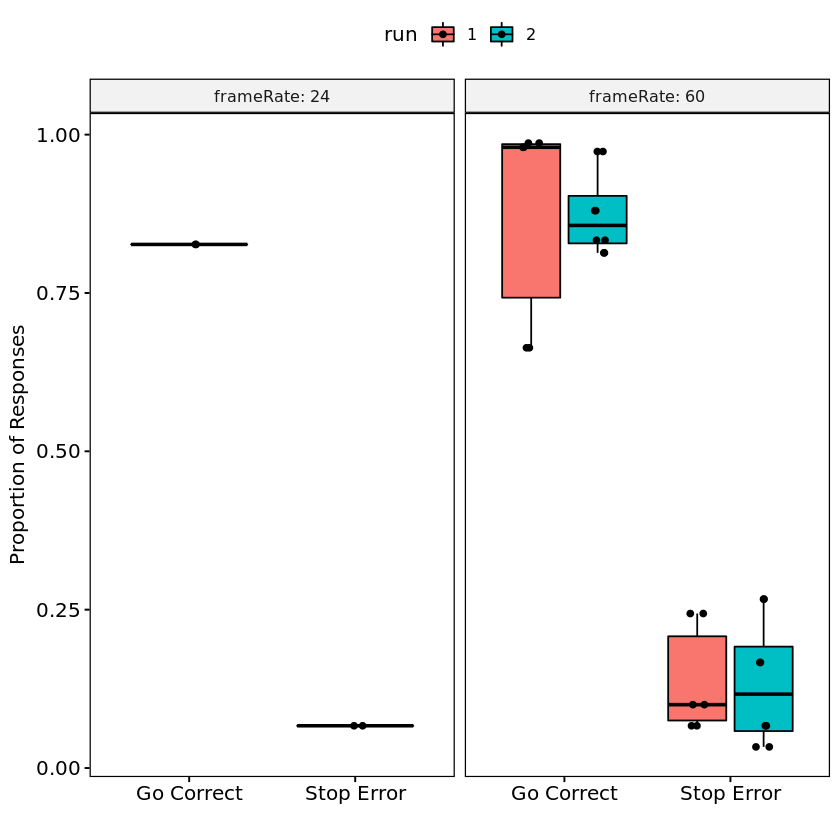

In [22]:

zero_ssd <- merge(select(zero_ssd, c('participant', 'run', 'frameRate')), SST_prop, by = c('participant', 'run', 'frameRate') )
# zero_ssd <- merge(zero_ssd, SST_rt, by = c('participant', 'run', 'frameRate') )
zero_ssd %>% 
    group_by(condition, run) %>%
    ggboxplot(., "condition", "prop", fill = "run", ylab = "Proportion of Responses", xlab = "", facet.by = "frameRate", add = 'jitter', short.panel.labs = FALSE) + 
    scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 


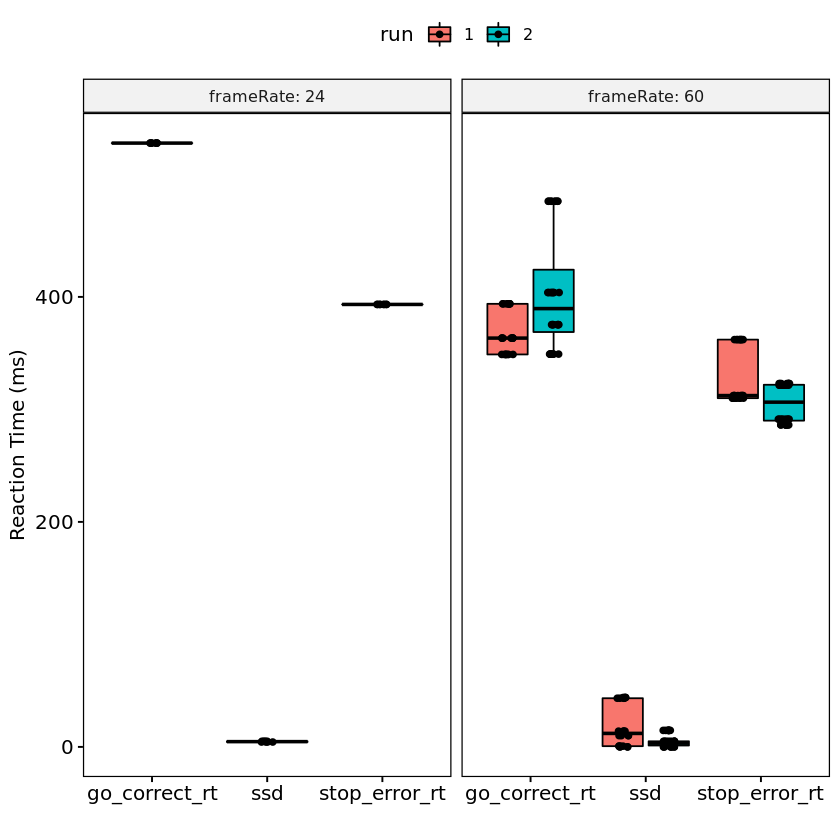

In [23]:

zero_ssd <- merge(select(zero_ssd, c('participant', 'run', 'frameRate')), SST_rt, by = c('participant', 'run', 'frameRate') )
# zero_ssd <- merge(zero_ssd, SST_rt, by = c('participant', 'run', 'frameRate') )
# zero_ssd
zero_ssd %>% 
    group_by(condition, run) %>%
    ggboxplot(., "condition", "RT", fill = "run", ylab = "Reaction Time (ms)", xlab = "", add = 'jitter', facet.by = "frameRate", short.panel.labs = FALSE) 
#     + scale_x_discrete(labels = c('Go Correct','Stop Error', 'SSD')) 

# coefficient of variation

/home/06028/tbweng/miniconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: `stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


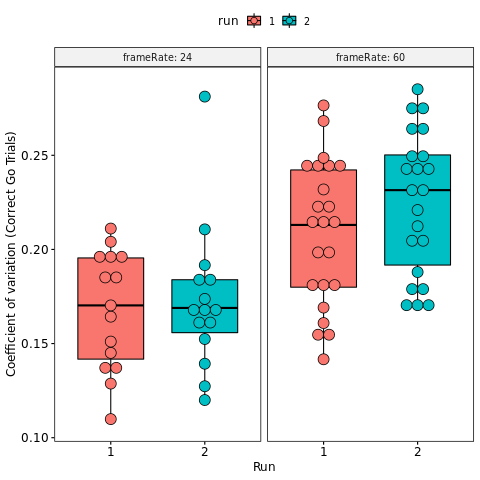

In [23]:


SST_long %>%
  filter(trial_type != "") %>%
  group_by(participant, run, trial_type, frameRate) %>%
  summarise(sd_rt = sd(key_response.rt, na.rm=TRUE), mean_rt = mean(key_response.rt, na.rm=TRUE)) %>%
  mutate(CoV = sd_rt/mean_rt) %>%
  filter(sd_rt > 0.001) %>%
  ggboxplot(., "trial_type", "CoV", fill = "run", ylab = "Coefficient of variation (all trials)", facet.by = "frameRate", xlab = "Trial Type", add = "dotplot", short.panel.labs = FALSE)

SST_long %>%
  filter(trial_type == 'go' & key_response.corr == 1) %>%
  group_by(participant, run, frameRate) %>%
  summarise(sd_rt = sd(key_response.rt), mean_rt = mean(key_response.rt)) %>%
  mutate(CoV = sd_rt/mean_rt) %>%
   filter(sd_rt > 0.001) %>% 
  ggboxplot(., "run", "CoV", fill = "run", ylab = "Coefficient of variation (Correct Go Trials)", xlab = "Run", facet.by = "frameRate", add = "dotplot", short.panel.labs = FALSE)